<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

This notebook is based on [this example](https://github.com/microsoft/recommenders/blob/main/examples/02_model_collaborative_filtering/standard_vae_deep_dive.ipynb) and adapted to our needs. 

## Prerequisites

To run this notebook on Windows, either use Google Colab or make use of the Docker file in [this](https://github.com/microsoft/recommenders/tree/main/tools/docker) repository.

# Standard Variational Autoencoders for Collaborative Filtering on Amazong Fashion dataset. 
This notebook accompanies the paper "*A Hybrid Variational Autoencoder for Collaborative Filtering*" by Kilol Gupta, Mukund Y. Raghuprasad, Pankhuri Kumar [[Gupta et al.,2018]](https://arxiv.org/pdf/1808.01006.pdf). We will study a part of this paper, more specific, the derivation of the "*Standard Variational Autoencoder*" [[Gupta et al.,2018, chapter 5.1]](https://arxiv.org/pdf/1808.01006.pdf) . 

The "*Standard Variational Autoencoder*" is enhanced using $\mathbf \beta$-VAE [[Higgins et al, 2016]](https://openreview.net/pdf?id=Sy2fzU9gl), [[Burgess et al, 2018]](https://arxiv.org/pdf/1804.03599.pdf). Also, for tuning the parameter $\mathbf \beta$ an annealing methodology is used based on [[Bowman et al, 2015]](https://arxiv.org/pdf/1511.06349.pdf) and [[Liang, Dawen, et al,2018]](https://dl.acm.org/doi/pdf/10.1145/3178876.3186150?casa_token=Heh8W001edYAAAAA:P_y4buj0zb2ml8GpDXONkrc3EYEBOxgjZNAJOuqes60aeJ4C1Vg1Wq5Eh6mkCXhxNKp38pO_eUw).


In this notebook, we will show a complete self-contained example of training a "*Standard Variational Autoencoder*" with a simple ELBO function/loss (described in the original paper) and the prosposed extention of it. The public [Amazon dataset](https://nijianmo.github.io/amazon/index.html) is used for training and evaluating our model, with subcategory Fashion. For this notebook it is assumed that the reader has basic knowledge about VAE [[Kingma et al, 2013]](https://arxiv.org/pdf/1312.6114.pdf). 





# 0 Global Settings and Imports

In [69]:
# download the necessary libraries 
! pip install tensorflow==2.2.0-rc1
! pip install keras==2.3.1
! pip install papermill
! pip install recommenders[examples,gpu]

  Using cached scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl (26.1 MB)
  Using cached tensorflow_estimator-2.2.0-py2.py3-none-any.whl (454 kB)
  Using cached tensorboard-2.1.1-py3-none-any.whl (3.8 MB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.6.1
    Uninstalling scipy-1.6.1:
      Successfully uninstalled scipy-1.6.1
  Attempting uninstall: gast
    Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
ERROR: pip's dependency resolver does not currently take into acc

  Using cached tensorflow_estimator-1.15.1-py2.py3-none-any.whl (503 kB)
  Using cached gast-0.2.2-py3-none-any.whl
  Using cached tensorboard-1.15.0-py3-none-any.whl (3.8 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Attempting uninstall: gast
    Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.2.0rc1 requires gast==0.3.3, but you have gast 0.2.2 which is incompatible.
tensorflow 2.2.0rc1 requires tensorb

In [70]:
!pip install scipy==1.6.1

  Using cached scipy-1.6.1-cp37-cp37m-manylinux1_x86_64.whl (27.4 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.2.0rc1 requires gast==0.3.3, but you have gast 0.2.2 which is incompatible.
tensorflow 2.2.0rc1 requires scipy==1.4.1; python_version >= "3", but you have scipy 1.6.1 which is incompatible.
tensorflow 2.2.0rc1 requires tensorboard<2.2.0,>=2.1.0, but you have tensorboard 1.15.0 which is incompatible.
tensorflow 2.2.0rc1 requires tensorflow-estimator<2.3.0,>=2.2.0rc0, but you have tensorflow-estimator 1.15.1 which is incompatible.


In [71]:
import sys
import os
import json
import numpy as np
import pandas as pd
import papermill as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import tensorflow as tf
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.models import Model

from recommenders.utils.timer import Timer
from recommenders.datasets.split_utils import min_rating_filter_pandas
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.constants import SEED as DEFAULT_SEED

from recommenders.datasets.sparse import AffinityMatrix
from recommenders.utils.python_utils import binarize
from recommenders.models.vae.standard_vae import StandardVAE

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))

tf.compat.v1.disable_eager_execution()

System version: 3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]
Pandas version: 1.3.5
Tensorflow version: 2.2.0-rc1
Keras version: 2.3.1


In [72]:
# top 10 items to recommend, the fashion dataset does not contain too many products.
TOP_K = 10

# Model parameters
HELDOUT_USERS_VAL_PERC = 0.1 # CHANGE FOR DIFFERENT DATASIZE
HELDOUT_USERS_TEST_PERC = 0.2 # CHANGE FOR DIFFERENT DATASIZE
INTERMEDIATE_DIM = 50
LATENT_DIM = 10
EPOCHS = 50
BATCH_SIZE = 10

# temporary Path to save the optimal model's weights
WEIGHTS_PATH = os.path.join(".save_weights.hdf5")

SEED = 98765

In [111]:
class StandardRealValueVAE(StandardVAE):
    """
    Using inheritence we overloaded the methods to create real valued output for the VAE. 
    We used a MSE loss instead of a BCE and applied a softmax activation function on the last layer. 
    Additionally we applied a Lambda layer to scale the softmax layer to be in the 1-5 range.
    """
    
    def __init__(self, min_rating, max_rating, *args, **kwargs):
        self.min_rating = min_rating
        self.max_rating = max_rating
        self.scale_to_rating = Lambda(self._scale_rating)
        super(StandardRealValueVAE, self).__init__(*args, **kwargs)
        
    def _scale_rating(self, x):
        return x * (self.max_rating - self.min_rating) + self.min_rating
    
    def _create_model(self):
        """Build and compile model."""
        # Encoding
        self.x = Input(shape=(self.original_dim,))
        self.dropout_encoder = Dropout(self.drop_encoder)(self.x)
        self.h = Dense(self.intermediate_dim, activation="tanh")(self.dropout_encoder)
        self.z_mean = Dense(self.latent_dim)(self.h)
        self.z_log_var = Dense(self.latent_dim)(self.h)

        # Sampling
        self.z = Lambda(self._take_sample, output_shape=(self.latent_dim,))(
            [self.z_mean, self.z_log_var]
        )

        # Decoding
        self.h_decoder = Dense(self.intermediate_dim, activation="tanh")
        self.dropout_decoder = Dropout(self.drop_decoder)
        self.x_bar = Dense(self.original_dim, activation = "softmax")
        self.h_decoded = self.h_decoder(self.z)
        self.h_decoded_ = self.dropout_decoder(self.h_decoded)
        self.x_decoded = self.x_bar(self.h_decoded_)
        self.x_decoded = self.scale_to_rating(self.x_decoded)

        # Training
        self.model = Model(self.x, self.x_decoded)
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=self._get_vae_loss,
        )
        
    def _get_vae_loss(self, x, x_bar):
        """Calculate negative ELBO (NELBO)."""
        # Reconstruction error: logistic log likelihood
        reconst_loss = self.original_dim * mean_squared_error(x, x_bar)

        # Kullback–Leibler divergence
        kl_loss = 0.5 * K.sum(
            -1 - self.z_log_var + K.square(self.z_mean) + K.exp(self.z_log_var), axis=-1
        )

        return reconst_loss + self.beta * kl_loss

# 1 Standard-VAE algorithm


__Notations__: We use $u \in \{1,\dots,U\}$ to index users and $i \in \{1,\dots,I\}$ to index items. In this work, we consider learning with implicit feedback. The user-by-item interaction matrix is the click matrix $\mathbf{X} \in \mathbb{N}^{U\times I}$. The lower case $\mathbf{x}_u =[X_{u1},\dots,X_{uI}]^\top \in \mathbb{N}^I$ is a bag-of-words vector with the number of ratings for each item from user u. The original notebook used a binarized click matrix, but to create a better comparison between the different CF recommender systems, we decided to create a VAE with real valued output between 1 and 5.

__Standard-VAE Model__: Autoencoder based recommendation is an unsupervised model attempting to reconstruct its input data in the output layer. The middle layer (bottleneck layer) is used as a salient feature representation of the input data. In this notebook, we study the standard variational autoencoder and derive the variational lower bound loss function of the standard variational autoencoder. The output of the SVAE is a probability distribution over the K items. This differs from the normal VAE that has the final output as the reconstructed input. So, the SVAE takes the user ratings in the form of a click matrix, $\mathbf{x}_u$, as inputs and then are encoded to learn the mean, $\mathbf{m}_u$, and the standard deviation, $\mathbf{\sigma}_u$, of the K-dimensional latent representation through the encoder function, $\mathbf{g}_\phi(\mathbf{x}_u)$ = $\mathbf{m}_u$, $\mathbf{\sigma}_u$. In other words, the latent vector for each user,  $\mathbf{z}_u$, is sampled from the Gaussian distribution, where $\mathbf{z}_u$ ∼ N($\mathbf{m}_u$, $\mathbf{\sigma}_u$). Then, the decoder function, $\mathbf{f}_\theta$($\mathbf{z}_u$) = $\mathbf{\pi}_u$, is used to decode the latent vector from K-dimensional space to a probability distribution $\mathbf{\pi}_u$ in the original N-dimensional space. As a result, we get the probabilities of each of the N products being viewed by each user.

The objective __function/loss__ used in the model is the __ELBO__:

$$Loss= \log p_\theta(\mathbf{x}_u | \mathbf{z}_u) -  KL (q(\mathbf{z}_u)||p(\mathbf{z}_u|\mathbf{x}_u))$$

where:
* $\mathbf{x}_u$: the product feature vector
* $\mathbf{z}_u$: latent representation of $\mathbf{x}_u$
* $KL$: The Kullback-Leibler divergence measure

The first part of the ELBO equation considers the logistic log-likelihood for a product given its latent representation (reconstruction error), while the second KL term can be viewed as a regularization part. Our goal is to maximize __ELBO__, which is equivalent to minimizing the negative ELBO  (__NELBO__).

The logistic log-likelihood fuction is given as, $$\log p_\theta(\mathbf{x}_u | \mathbf{z}_u) = \sum_{i} \mathbf{x}_{ui} \log \mathbf{\sigma}(\mathbf{f}_{ui}) + (1 - \mathbf{x}_{ui}) \log(1 - \mathbf{\sigma}(\mathbf{f}_{ui})) $$

where: 
* $\mathbf{\sigma}(\mathbf{x}) = 1 / (1+ \exp(-\mathbf{x}))$ taken over all the products i.

In addition, we extended the **ELBO** by introducing a parameter $\beta$  ([Higgins et al, 2016](https://openreview.net/pdf?id=Sy2fzU9gl), [Burgess et al, 2018](https://arxiv.org/pdf/1804.03599.pdf) ) to control the strength of regularization:

$$
Loss= \log p_\theta(\mathbf{x}_u | \mathbf{z}_u) - \mathbf{\beta}  KL (q(\mathbf{z}_u)||p(\mathbf{z}_u|\mathbf{x}_u))
$$



Τhe regularization view of the **ELBO** introduces a
trade-off between how well we can fit the data and how close the
approximate posterior stays to the prior during learning. By introducing the parameter $\mathbf{\beta}$ < 1, we are weakening the influence of the prior constraint. As a result, the model is less able to generate novel user histories by ancestral sampling. It is important to mention that our goal is not to maximize likelihood or generate imagined user histories, rather, our goal is to make good recommendations. So by treating $\mathbf{\beta}$ as a free regularization parameter yields significant improvements in performance. We propose two different experiments. 

At first, the training of the model is being done by setting $\mathbf{\beta}$=1 [[Gupta et al.,2018, chapter 5.1]](https://arxiv.org/pdf/1808.01006.pdf).


Finally, we introduce a simple heuristic for tuning $\mathbf{\beta}$. We anneal the KL divergence all the way to a specific value of $\mathbf{\beta}$, reaching that value at around 80% of the total number of epochs used during the training process. Then we identify the best performing  $\mathbf{\beta}$  based on the peak validation metric, and retrain the model with the same annealing schedule, but for the rest of epochs we are not increasing  $\mathbf{\beta}$  after reaching its optimal value.

It can be hard to imagine how to evaluate a recommender system. The primary concern of recommender systems is that they need to be able to put relevant items very high up the list of recommendations. So we need rank-aware metrics to select recommenders that aim at these two primary goals:

1.	Where does the recommender place the items it suggests?
2.	How good is the recommender at modeling relative preference?
 
So, the rank-aware metric we use is the Normalized Discounted Cumulative Gain. NDCG value putting highly relevant documents high up the recommended lists. It is able to use the fact that some documents are “more” relevant than others. It compares the predicted rank of the held-out items with their true rank. The metric recall, primarily concerned with being good at finding things. We need metrics that emphasis being good at finding and ranking things, like NDCG. That's why we emphasize in NDCG.





# 2 Keras implementation of Standard VAE

For the implementation of the model, Keras package is used. 

# 3 Data Preparation

### 3.1 Load data and split

We load the data and create train / validation / test splits following strong generalization: 

- We split all unique users into training users and heldout users (i.e. validation and test users)

- By using the lists of these users, we obtain corresponding training data and heldout data.

- We train models using the entire rating vector of the training users. 

- To evaluate, we take part of the reviews from heldout (validation and test) data to learn the necessary user-level representations for the model and then compute metrics by looking at how well the model ranks the rest of the unseen ratings from the heldout data

#### 3.1.1 Load data

In [74]:
df = pd.DataFrame()
df[["userID", "itemID", "rating", "timestamp"]] = pd.read_json("../data/AMAZON_FASHION_5.json")[["reviewerID", "asin", "overall", "unixReviewTime"]]
df.drop_duplicates(subset=["userID", "itemID"], inplace=True)
df.head()

,userID,itemID,rating,timestamp
0,ALJ66O1Y6SLHA,B000K2PJ4K,5,144132480
5,A3W11493KS6Z2L,B000K2PJ4K,3,143087040
10,A3HX4X3TIABWOV,B000KPIHQ4,2,151683840
11,AW8UBYMNJ894V,B000KPIHQ4,2,148357440
12,A265UZVOZWTTXQ,B000KPIHQ4,5,147666240


In [75]:
df.shape

(3042, 4)

#### 3.1.2 Data Filtering 



For the data filtering we are using the below 3 steps which are recommended by the original paper [[Liang, Dawen, et al,2018]](https://dl.acm.org/doi/pdf/10.1145/3178876.3186150?casa_token=zul5haircsAAAAAA:iIKn7y-xWwSeqaP-MmmyUaJoJuNZX9Fx1aXeFJwkwtMpVDCrPMW3kZjuYo1LKhSuMeUMNf1mbP2o).


We have to make sure that :
 - user-to-product interactions with rating <=3.5 are filtered out. Applying this filtering we make sure that if a product is rated less than 3.5 from the users that they watched this product, it will not be contained in the final click matrix. If we do not apply this filter, the final click matrix will be even sparser.
 - the users who clicked less than 5 products are filtered out. 
 - the products which are not clicked by any user are filtered out.


In [76]:
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()
print(df.shape, usercount.shape, itemcount.shape)

(3042, 4) (406, 2) (31, 2)


In [77]:
# Keep users who clicked on at least 3 items (original dataset was supposed to have atleast 5 reviews/ratings, 
# but since this was also reviews on subtypes of the same product and we had to drop these duplicates, we have to refilter)
df = min_rating_filter_pandas(df, min_rating=3, filter_by="user")

# Keep products that were clicked on by at least on 1 user
df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")

In [78]:
# Obtain both usercount and itemcount after filtering
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()
print(df.shape, usercount.shape, itemcount.shape)

density = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d ratings from %d users on %d products (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], (1 - density) * 100))

(3010, 4) (388, 2) (27, 2)
After filtering, there are 3010 ratings from 388 users on 27 products (sparsity: 71.268%)


In [79]:
df.to_json("../data/AMAZON_FASHION_5.71.268.json")

In [80]:
# Binarize the data (only keep ratings >= 4)
df_preferred = df[df['rating'] > 3.5]
print (df_preferred.shape)
df_low_rating = df[df['rating'] <= 3.5]


df_preferred.head(10)

(2515, 4)


,userID,itemID,rating,timestamp
25,AGZ5OOZVDO194,B000YFSR5G,5,151804800
26,A3GJ3DJU1RXOHN,B000YFSR4W,4,127794240
28,A2ON4RYI9Z4SQ,B000YFSR5G,5,150793920
31,A1EZN3E9R322YJ,B000YFSR5G,5,149757120
37,AGZ5OOZVDO194,B000YFSR4W,5,151804800
38,A2BFZUQ2XV535H,B000YFSR5G,5,148919040
41,A1Y01U6OZLZE7I,B000YFSR5G,4,148763520
53,A36GNVEQP92OPA,B000YFSR5G,5,142300800
55,A2ON4RYI9Z4SQ,B000YFSR4W,5,150793920
56,A3GJ3DJU1RXOHN,B000YFSR5G,4,127794240


In [81]:
df = df_preferred

# Obtain both usercount and itemcount after filtering
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()
print(df.shape, usercount.shape, itemcount.shape)

density = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d ratings from %d users on %d products (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], (1 - density) * 100))

(2515, 4) (327, 2) (24, 2)
After filtering, there are 2515 ratings from 327 users on 24 products (sparsity: 67.954%)


#### 3.1.3 Split data

For data slitting we use:
- 600 (~ 10%) users in validation set 
- 600 (~ 10%) users in testing set 
- the rest of them (~ 80%) in training set

Since the model is trained using the click history of the training users, we have to make sure that the products that exist in the validation and test sets are the products that exist in the train set. In other words, validation and test set should not contain products that do not exist in the train set.

In [82]:
unique_users = sorted(df.userID.unique())
np.random.seed(SEED)
unique_users = np.random.permutation(unique_users)

In [83]:
# Create train/validation/test users 
# The order of splitting is val, test and then training to solve the rounding error for int() on line 5, 6
n_users = len(unique_users)
print("Number of unique users:", n_users)
HELDOUT_USERS_VAL = int(HELDOUT_USERS_VAL_PERC * n_users)
HELDOUT_USERS_TEST = int(HELDOUT_USERS_TEST_PERC * n_users)

val_users = unique_users[:HELDOUT_USERS_VAL]
print("\nNumber of validation users:", len(val_users))

test_users = unique_users[HELDOUT_USERS_VAL:(HELDOUT_USERS_VAL+HELDOUT_USERS_TEST)]
print("\nNumber of test users:", len(test_users))

train_users = unique_users[(HELDOUT_USERS_VAL+HELDOUT_USERS_TEST):]
print("\nNumber of training users:", len(train_users))

Number of unique users: 327

Number of validation users: 32

Number of test users: 65

Number of training users: 230


In [84]:
# For training set keep only users that are in train_users list
train_set = df.loc[df['userID'].isin(train_users)]
print("Number of training observations: ", train_set.shape[0])

# For validation set keep only users that are in val_users list
val_set = df.loc[df['userID'].isin(val_users)]
print("\nNumber of validation observations: ", val_set.shape[0])

# For test set keep only users that are in test_users list
test_set = df.loc[df['userID'].isin(test_users)]
print("\nNumber of test observations: ", test_set.shape[0])

# train_set/val_set/test_set contain user - product interactions with rating 4 or 5

Number of training observations:  1766

Number of validation observations:  249

Number of test observations:  500


In [85]:
# Obtain list of unique products used in training set
unique_train_items = pd.unique(train_set['itemID'])
print("Number of unique items that rated in training set", unique_train_items.size)

Number of unique items that rated in training set 22


In [86]:
# For validation set keep only products that used in training set
val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
print("Number of validation observations after filtering: ", val_set.shape[0])

# For test set keep only products that used in training set
test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
print("\nNumber of test observations after filtering: ", test_set.shape[0])

Number of validation observations after filtering:  248

Number of test observations after filtering:  498


## 3.2 Click matrix generation 

From section 3.1 we end up with 3 datasets train_set, val_set and test_set.  For our model we need to give a click matrix as an input that contains only 0-s and 1-s, where each row represents a user and each column represents a product. 
So, the click matrix contains the preferences of the user, marking each cell with 0 when the user did not enjoy (ratings below 3.5) or did not watch a product and with 1 when the user enjoyed a product (ratings above 3.5).

The training set will be a click matrix containing full historicity of all training users. However, the test set and validation set should be splitted into train and test parts. As a result, we get 4 datasets:
- val_data_tr
- val_data_te
- test_data_tr
- test_data_te


'val_data_tr' contains 75% of the the preferred products (products marked as 1 in the click matrix) per user.
The rest 25% of the preffered products are contained into the 'val_data_te'. The same splitting is followed for test set. 

The 'val_data_tr' is given as an input for our model at the end of each epoch. The result of the model is a 'reconstructed_val_data_tr', which contains the products recommended for each user by the model. In order to evaluate the performance of the model, at the end of each epoch, we compare the 'reconstructed_val_data_tr' (predicted recommendations by the model) with the 'val_data_te' (true product preferences of each user) using NDCG@k metric. 

For the final evaluation of the model the 'test_data_tr' and 'test_data_te' are being used. As we described before, the 'test_data_tr' is given as an input for the model and returns the 'reconstructed_test_data_tr' dataset with the recommendations made by the model. Then, the 'reconstructed_test_data_tr' is compared with 'test_data_te' through different metrics:
- MAP
- NDCG@k
- Recall@k
- Precision@k






In [87]:
# Instantiate the sparse matrix generation for train, validation and test sets
# use list of unique items from training set for all sets
am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)

am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)

am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)

In [88]:
# Obtain the sparse matrix for train, validation and test sets
train_data, _, _ = am_train.gen_affinity_matrix()
print(train_data.shape)

val_data, val_map_users, val_map_items = am_val.gen_affinity_matrix()
print(val_data.shape)

test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()
print(test_data.shape)

(230, 22)
(32, 22)
(64, 22)


In [89]:
# Split validation and test data into training and testing parts
val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=SEED)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=SEED)

In [90]:
# Just checking
print(np.sum(val_data))
print(np.sum(val_data_tr))
print(np.sum(val_data_te))

1210
903
307


In [91]:
# Just checking
print(np.sum(test_data))
print(np.sum(test_data_tr))
print(np.sum(test_data_te))

2410
1810
600


# 4 Train Standard-VAE using Keras


__Model Architecture:__

For "MovieLens-1M dataset", we set both the generative function and the inference model to be 3-layer multilayer perceptron (MLP) with symmetrical architecture.
The generative function is a [70 -> 200 -> n_items] MLP, which means the inference function is a [n_items -> 200 -> 70] MLP. Thus the overall architecture for the Multi-VAE is [n_items -> 200 -> 70 -> 200 -> n_items]. 

Also, Dropout is applied both in encoder and decoder to avoid overfitting. 

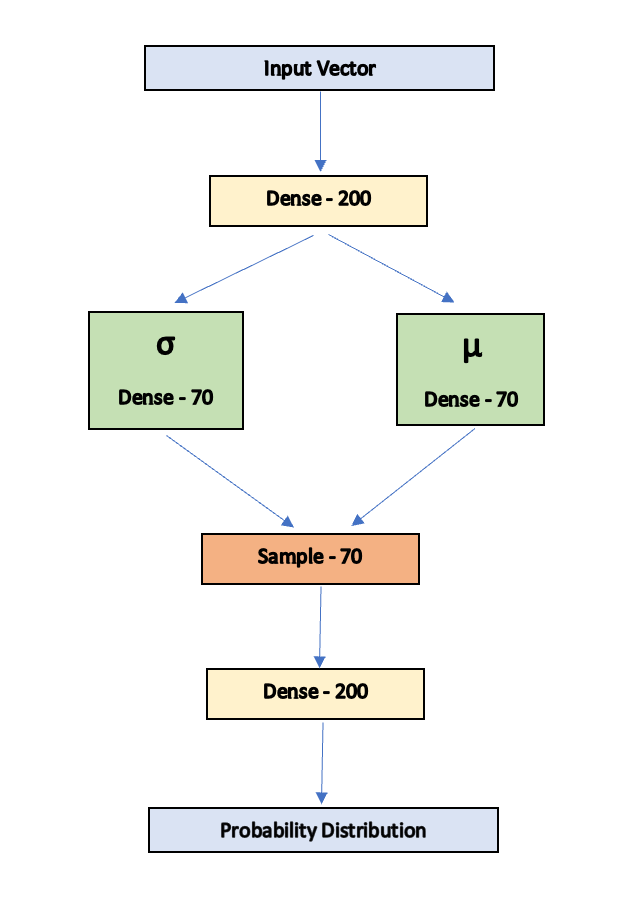

## 4.1 Standard VAE without annealing  (initial approach)

Firstly, we train Standard-VAE model using constant $\mathbf \beta$= 1.



In [92]:
model_without_anneal = StandardRealValueVAE(min_rating = 1,
                                            max_rating = 5,
                                            n_users=train_data.shape[0], # Number of unique users in the training set
                                            original_dim=train_data.shape[1], # Number of unique items in the training set
                                            intermediate_dim=INTERMEDIATE_DIM, 
                                            latent_dim=LATENT_DIM, 
                                            n_epochs=EPOCHS, 
                                            batch_size=BATCH_SIZE, 
                                            k=TOP_K,
                                            verbose=0,
                                            seed=SEED,
                                            save_path=WEIGHTS_PATH,
                                            drop_encoder=0.5,
                                            drop_decoder=0.5,
                                            annealing=False,
                                            beta=1.0)

In [93]:
with Timer() as t:
    model_without_anneal.fit(x_train=train_data, 
                             x_valid=val_data, 
                             x_val_tr=val_data_tr, 
                             x_val_te=val_data_te, # with the original ratings 
                             mapper=am_val
                             )
print("Took {} seconds for training.".format(t))

Took 8.4052 seconds for training.


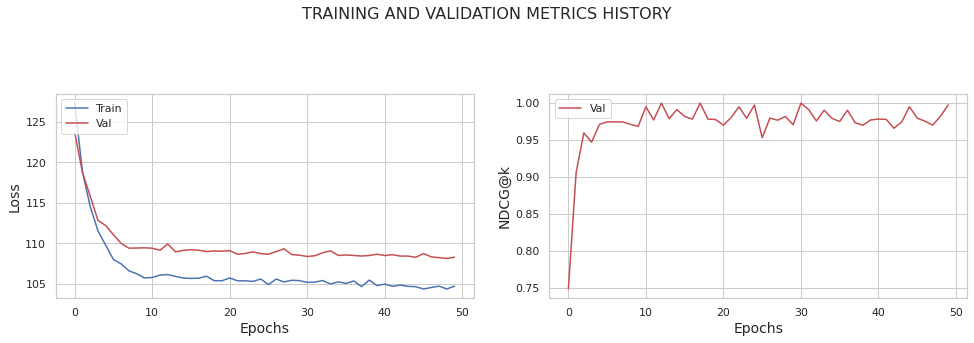

In [94]:
model_without_anneal.display_metrics() 

In [95]:
ndcg_val_without_anneal = model_without_anneal.ndcg_per_epoch()

#### Prediction and Evaluation of Standard-VAE model using constant $\beta$ = 1.

Evaluate with recommending 5 items.

In [96]:
eval_k = 5
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=eval_k,
                                                    remove_seen=True)
    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te, kind='ratings') # use test_data_te_, with the original ratings
    

print("Took {} seconds for prediction.".format(t))
# Use the ranking metrics for evaluation
eval_map_1 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_ndcg_1 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_precision_1 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_recall_1 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)

print(f"MAP@{eval_k}:\t\t{eval_map_1:.5f}",
      f"NDCG@{eval_k}:\t\t{eval_ndcg_1:.5f}",
      f"Precision@{eval_k}:\t{eval_precision_1:.5f}",
      f"Recall@{eval_k}: \t{eval_recall_1:.5f}", sep='\n')

Took 0.1515 seconds for prediction.
MAP@5:		0.97619
NDCG@5:		0.98246
Precision@5:	0.39048
Recall@5: 	0.99206


Evaluate with recommending 10 items.

In [97]:
eval_k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=eval_k,
                                                    remove_seen=True)
    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_2 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_ndcg_2 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_precision_2 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_recall_2 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)

print(f"MAP@{eval_k}:\t\t{eval_map_2:.5f}",
      f"NDCG@{eval_k}:\t{eval_ndcg_2:.5f}",
      f"Precision@{eval_k}:\t{eval_precision_2:.5f}",
      f"Recall@{eval_k}: \t{eval_recall_2:.5f}", sep='\n')

Took 0.0372 seconds for prediction.
MAP@10:		0.96693
NDCG@10:	0.97664
Precision@10:	0.19683
Recall@10: 	1.00000


## 4.2 Standard VAE with annealing 
We are going to use annealing procedure for finding the optimal $\mathbf \beta$.

Now, in order to find the optimal $\beta$, we train our model using annealing with anneal_cap equal 1.0.






In [98]:
model_with_anneal = StandardRealValueVAE(min_rating = 1,
                                         max_rating = 5,
                                         n_users=train_data.shape[0], # Number of unique users in the training set
                                         original_dim=train_data.shape[1], # Number of unique items in the training set
                                         intermediate_dim=INTERMEDIATE_DIM, 
                                         latent_dim=LATENT_DIM, 
                                         n_epochs=EPOCHS, 
                                         batch_size=BATCH_SIZE, 
                                         k=TOP_K,
                                         verbose=0,
                                         seed=SEED,
                                         save_path=WEIGHTS_PATH,
                                         drop_encoder=0.5,
                                         drop_decoder=0.5,
                                         annealing=True,
                                         anneal_cap=1.0)

In [99]:
with Timer() as t:
    model_with_anneal.fit(x_train=train_data, 
                          x_valid=val_data, 
                          x_val_tr=val_data_tr, 
                          x_val_te=val_data_te, #  with the original ratings
                          mapper=am_val
                          )
print("Took {} seconds for training.".format(t))

Took 11.0683 seconds for training.


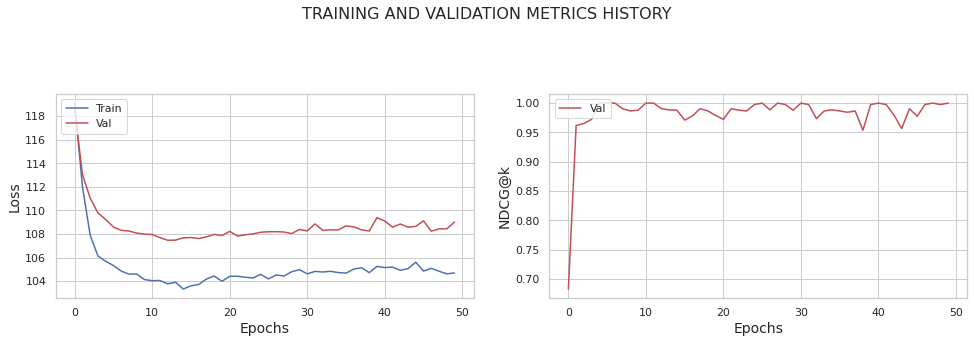

In [100]:
model_with_anneal.display_metrics()

In [101]:
ndcg_val_with_anneal = model_with_anneal.ndcg_per_epoch()

Using the optimal beta as anneal cap , we retrain our model. 

When NDCG@k of validation set reach a peak, the weights of the model are saved. Using this model we evaluate the test set. 

In [102]:
# Get optimal beta 
optimal_beta = model_with_anneal.get_optimal_beta()
print( "The optimal beta is: ", optimal_beta)

The optimal beta is:  0.125


In [103]:
model_optimal_beta = StandardRealValueVAE(min_rating = 1,
                                          max_rating = 5,
                                          n_users=train_data.shape[0], # Number of unique users in the training set
                                          original_dim=train_data.shape[1], # Number of unique items in the training set
                                          intermediate_dim=INTERMEDIATE_DIM,
                                          latent_dim=LATENT_DIM,
                                          n_epochs=EPOCHS,
                                          batch_size=BATCH_SIZE,
                                          k=TOP_K,  
                                          verbose=0,
                                          seed=SEED,
                                          save_path=WEIGHTS_PATH,
                                          drop_encoder=0.5,
                                          drop_decoder=0.5,
                                          annealing=True,
                                          anneal_cap=optimal_beta,  
                                         )

In [104]:
with Timer() as t:
    model_optimal_beta.fit(x_train=train_data, 
                           x_valid=val_data, 
                           x_val_tr=val_data_tr, 
                           x_val_te=val_data_te, # with the original ratings
                           mapper=am_val
                           )
print("Took {} seconds for training.".format(t))

Took 12.5368 seconds for training.


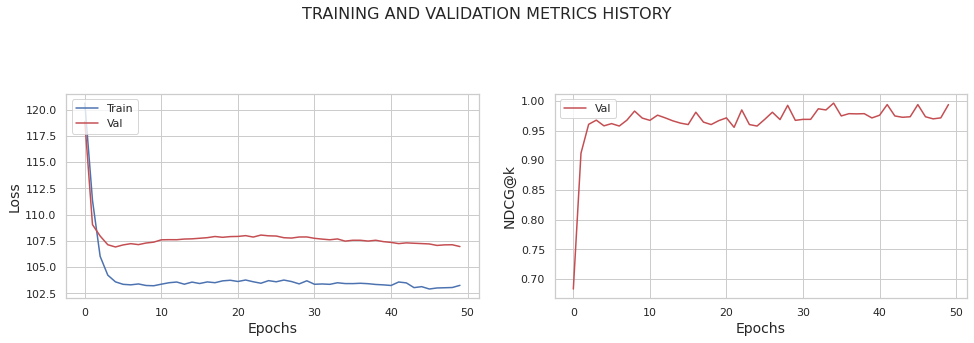

In [105]:
 model_optimal_beta.display_metrics()

In [106]:
ndcg_val_optimal_beta = model_optimal_beta.ndcg_per_epoch()

#### Prediction and Evaluation of Standard-VAE model using the optimal $\beta$ with annealing.

Evaluate with recommending 10 items.

In [107]:
eval_k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_optimal_beta.recommend_k_items(x=test_data_tr,
                                                  k=eval_k,
                                                  remove_seen=True)
    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)

print(f"MAP@{eval_k}:\t\t{eval_map_3:.5f}",
      f"NDCG@{eval_k}:\t{eval_ndcg_3:.5f}",
      f"Precision@{eval_k}:\t{eval_precision_3:.5f}",
      f"Recall@{eval_k}: \t{eval_recall_3:.5f}", sep='\n')

Took 0.2209 seconds for prediction.
MAP@10:		0.98545
NDCG@10:	0.98928
Precision@10:	0.19683
Recall@10: 	1.00000


Evaluate with recommending 5 items.

In [108]:
eval_k = 5
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_optimal_beta.recommend_k_items(x=test_data_tr,
                                                  k=eval_k,
                                                  remove_seen=True)
    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)

print(f"MAP@{eval_k}:\t\t{eval_map_3:.5f}",
      f"NDCG@{eval_k}:\t\t{eval_ndcg_3:.5f}",
      f"Precision@{eval_k}:\t{eval_precision_3:.5f}",
      f"Recall@{eval_k}: \t{eval_recall_3:.5f}", sep='\n')

Took 0.0410 seconds for prediction.
MAP@5:		0.98413
NDCG@5:		0.98860
Precision@5:	0.39365
Recall@5: 	1.00000


# 5 Conclusion 

Through this notebook, it is proven that the VAE using annealing outperforms the model without annealing (using $\mathbf \beta$=1). Specifically, the results of evaluting the test set, for the the 2 different approaches, are:

| Model | NDCG@100  |NDCG@10 | 
| --- | --- | --- | 
| Standard-VAE (wihtout annealing, β=1)| 0.392 | 0.446 |
| Standard-VAE (with annealing, optimal β)| 0.443 | 0.496 | 


This annealing procedure is used as an efficient way to tune the parameter $\mathbf \beta$. Otherwise, training multiple models using different values of $\mathbf \beta$ can be really time consuming. 

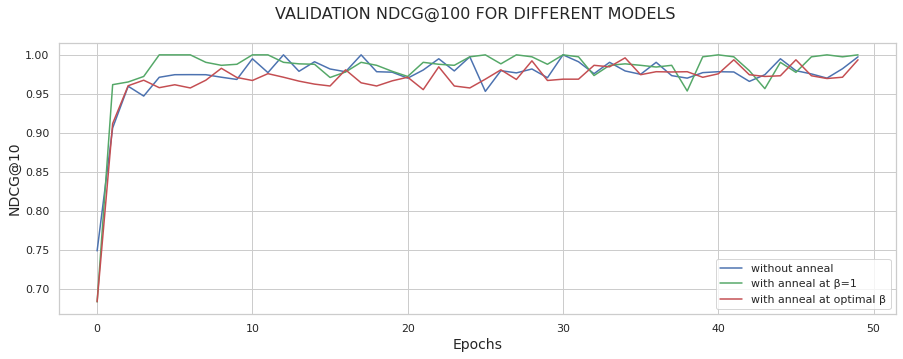

In [109]:
# Plot setup
plt.figure(figsize=(15, 5))
sns.set(style='whitegrid')

# Plot NDCG@k of validation sets for three models
plt.plot(ndcg_val_without_anneal, color='b', linestyle='-', label='without anneal')
plt.plot(ndcg_val_with_anneal, color='g', linestyle='-', label='with anneal at β=1')
plt.plot(ndcg_val_optimal_beta, color='r', linestyle='-', label='with anneal at optimal β')

# Add plot title and axis names
plt.title('VALIDATION NDCG@100 FOR DIFFERENT MODELS \n', size=16)
plt.xlabel('Epochs', size=14)
plt.ylabel('NDCG@10', size=14)
plt.legend(loc='lower right')

plt.show()


# Now we are going to vary the Sparsity
We will be doing this by splitting the difference (i.e. 100% - ~75% = 25%) up in 5 equal steps of 5% each. This would result in 75%, 80%, 85%, 90% and 95% sparsity. At each step we will perform a full round of training, validating and testing to see the performance of the VAE under data sparseness.


In [4]:
VERBOSE = False
def _print(message):
    if VERBOSE:
        print(message)
    

def load_dataset(fp):
    df = pd.DataFrame()
    try:
        df[["userID", "itemID", "rating", "timestamp"]] = pd.read_json(fp)[["reviewerID", "asin", "overall", "unixReviewTime"]]
    except:
        df = pd.read_json(fp)
    return df

def filter_on_minimal_ratings(df):
    # Keep users who clicked on at least 3 products
    df = min_rating_filter_pandas(df, min_rating=3, filter_by="user")

    # Keep products that were clicked on by at least on 1 user
    df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")
    df.reset_index(drop=True, inplace=True)
    return df

def filter_to_sparsity(df, sparsity_percentage, verbose = False):
    # Obtain both usercount and itemcount after filtering
    usercount = df[['userID']].groupby('userID', as_index = False).size()
    itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))

    _print(f"After filtering, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})")
    
    drop_item_ratings = int(-((1-sparsity_percentage) * (usercount.shape[0] * itemcount.shape[0]) - df.shape[0]))
    _print(f"To obtain a sparsity of {sparsity_percentage * 100}% we need to drop {drop_item_ratings} ratings")
    # Only remove ratings where the item is present more than 1 time in the dataset. This way items won't be fully omitted from the dataset.
    drop_indices = np.random.choice(df[df.itemID.isin((df.groupby('itemID').count() > 1).index)].index, size=drop_item_ratings)
    df.drop(drop_indices, inplace=True) # Future work: make sure stratified subsampling to make sure you won't drop products completely

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))
    _print(f"After dropping cells, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})")
    return df

def split_dataframe(df, val_percentage=0.1, test_percentage=0.2):
    unique_users = sorted(df.userID.unique())
    np.random.seed(SEED)
    unique_users = np.random.permutation(unique_users)
    
    # Create train/validation/test users 
    # The order of splitting is val, test and then training to solve the rounding error for int() on line 5, 6
    n_users = len(unique_users)
    _print(f"Number of unique users: {n_users}")
    HELDOUT_USERS_VAL = int(val_percentage * n_users)
    HELDOUT_USERS_TEST = int(test_percentage * n_users)

    val_users = unique_users[:HELDOUT_USERS_VAL]
    _print(f"\nNumber of validation users: {len(val_users)}")

    test_users = unique_users[HELDOUT_USERS_VAL:(HELDOUT_USERS_VAL+HELDOUT_USERS_TEST)]
    _print(f"\nNumber of test users: {len(test_users)}")

    train_users = unique_users[(HELDOUT_USERS_VAL+HELDOUT_USERS_TEST):]
    _print(f"\nNumber of training users: {len(train_users)}")
    
    # For training set keep only users that are in train_users list
    train_set = df.loc[df['userID'].isin(train_users)]
    _print(f"Number of training observations: {train_set.shape[0]}")

    # For validation set keep only users that are in val_users list
    val_set = df.loc[df['userID'].isin(val_users)]
    _print(f"\nNumber of validation observations: {val_set.shape[0]}")

    # For test set keep only users that are in test_users list
    test_set = df.loc[df['userID'].isin(test_users)]
    _print(f"\nNumber of test observations: {test_set.shape[0]}")

    # Obtain list of unique products used in training set
    unique_train_items = pd.unique(train_set['itemID'])
    _print(f"Number of unique items that rated in training set {unique_train_items.size}")
    
    # For validation set keep only products that used in training set
    val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
    _print(f"Number of validation observations after filtering: {val_set.shape[0]}")

    # For test set keep only products that used in training set
    test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
    _print(f"\nNumber of test observations after filtering: {test_set.shape[0]}")
    return train_set, val_set, test_set
    
def create_matrix(train_set, val_set, test_set):
    # Instantiate the sparse matrix generation for train, validation and test sets
    # use list of unique items from training set for all sets
    unique_train_items = pd.unique(train_set['itemID'])
    am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)
    am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)
    am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)
    
    # Obtain the sparse matrix for train, validation and test sets
    train_data, _, _ = am_train.gen_affinity_matrix()
    _print(train_data.shape)

    val_data, val_map_users, val_map_items = am_val.gen_affinity_matrix()
    _print(val_data.shape)

    test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()
    _print(test_data.shape)
    
    # Split validation and test data into training and testing parts
    val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=SEED)
    test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=SEED)
    return train_data, am_val, val_data, val_data_tr, val_data_te, am_test, test_data, test_data_tr, test_data_te
    

def data_loading_pipeline(fp, sparsity_percentage=None, with_writing=False):
    """
    fp: str = Filepointer to desired user-item-ratings json.
    sparsity_percentage: float = value between 0-1.
    """
    df = load_dataset(fp)
    df = filter_on_minimal_ratings(df)
    df = filter_to_sparsity(df, sparsity_percentage)
    train_set, val_set, test_set = split_dataframe(df)
    train_data, am_val, val_data, val_data_tr, val_data_te_ratings, am_test, test_data, test_data_tr, test_data_te_ratings = create_matrix(train_set, val_set, test_set)
    return train_data, am_val, val_data, val_data_tr, val_data_te_ratings, am_test, test_data, test_data_tr, test_data_te_ratings


data_loading_pipeline("../data/AMAZON_FASHION_5.json", 0.75)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
   

In [207]:
metrics_at_sparsity_levels = dict()

### Training with 75% sparsity

In [5]:
def train(train_data, val_data, val_data_tr, val_data_te_ratings, am_val):
    model_with_anneal = StandardRealValueVAE(
        min_rating=1,
        max_rating=5,
        n_users=train_data.shape[0], # Number of unique users in the training set
        original_dim=train_data.shape[1], # Number of unique items in the training set
        intermediate_dim=INTERMEDIATE_DIM, 
        latent_dim=LATENT_DIM, 
        n_epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        k=TOP_K,
        verbose=0,
        seed=SEED,
        save_path=WEIGHTS_PATH,
        drop_encoder=0.5,
        drop_decoder=0.5,
        annealing=True,
        anneal_cap=1.0)
    with Timer() as t:
        model_with_anneal.fit(x_train=train_data, 
                              x_valid=val_data, 
                              x_val_tr=val_data_tr, 
                              x_val_te=val_data_te_ratings, #  with the original ratings
                              mapper=am_val)
    print("Took {} seconds for training.".format(t))
    return model_with_anneal
        

def tune(optimal_beta, train_data, val_data, val_data_tr, val_data_te_ratings, am_val):
    model_optimal_beta = StandardRealValueVAE(
        min_rating=1,
        max_rating=5,
        n_users=train_data.shape[0], # Number of unique users in the training set
        original_dim=train_data.shape[1], # Number of unique items in the training set
        intermediate_dim=INTERMEDIATE_DIM,
        latent_dim=LATENT_DIM,
        n_epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        k=TOP_K,  
        verbose=0,
        seed=SEED,
        save_path=WEIGHTS_PATH,
        drop_encoder=0.5,
        drop_decoder=0.5,
        annealing=True,
        anneal_cap=optimal_beta)

    with Timer() as t:
        model_optimal_beta.fit(x_train=train_data, 
                               x_valid=val_data, 
                               x_val_tr=val_data_tr, 
                               x_val_te=val_data_te_ratings, # with the original ratings
                               mapper=am_val
                              )
        print("Took {} seconds for training.".format(t))
        return model_optimal_beta

def evaluate(model_optimal_beta, test_data_tr, test_data_te_ratings, am_test, eval_k):
    with Timer() as t:
        # Model prediction on the training part of test set 
        top_k =  model_optimal_beta.recommend_k_items(x=test_data_tr,
                                                      k=eval_k,
                                                      remove_seen=True)
        # Convert sparse matrix back to df
        top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
        test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings

    print("Took {} seconds for prediction.".format(t))

    # Use the ranking metrics for evaluation
    eval_map = map_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
    eval_ndcg = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
    eval_precision = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
    eval_recall = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
    
    return eval_map, eval_ndcg, eval_precision, eval_recall

def train_tune_eval_pipeline(sparsity_percentage, run_n_times=20):
    maps, ndcgs, precisions, recalls = np.zeros(run_n_times), np.zeros(run_n_times), np.zeros(run_n_times), np.zeros(run_n_times)
    
    eval_k = TOP_K
    for i in range(run_n_times):
        SEED = i
        VERBOSE = False
        if i == 0:
            VERBOSE = True # Print data messages once
        
        train_data, am_val, val_data, val_data_tr, val_data_te_ratings, am_test, test_data, test_data_tr, test_data_te_ratings = data_loading_pipeline("../data/AMAZON_FASHION_5.json", sparsity_percentage)

        model_with_anneal = train(train_data, val_data, val_data_tr, val_data_te_ratings, am_val)

        model_optimal_beta = tune(model_with_anneal.get_optimal_beta(), train_data, val_data, val_data_tr, val_data_te_ratings, am_val)

        eval_map, eval_ndcg, eval_precision, eval_recall = evaluate(model_optimal_beta, test_data_tr, test_data_te_ratings, am_test, eval_k)
        
        maps[i] = eval_map
        ndcgs[i] = eval_ndcg
        precisions[i] = eval_precision
        recalls[i] = eval_recall
        
    model_with_anneal.display_metrics() 
    model_optimal_beta.display_metrics()
    print(f"mean MAP@{eval_k}:\t\t{maps.mean():.5f}",
          f"mean NDCG@{eval_k}:\t{ndcgs.mean():.5f}",
          f"mean Precision@{eval_k}:\t{precisions.mean():.5f}",
          f"mean Recall@{eval_k}: \t{recalls.mean():.5f}", sep='\n')
    return maps, ndcgs, precisions, recalls
    
    

Took 17.0894 seconds for training.
Took 17.7985 seconds for training.
Took 0.7551 seconds for prediction.
Took 20.6547 seconds for training.
Took 19.8922 seconds for training.
Took 0.8055 seconds for prediction.
Took 20.2752 seconds for training.
Took 20.9662 seconds for training.
Took 0.8853 seconds for prediction.
Took 21.1831 seconds for training.
Took 22.0978 seconds for training.
Took 0.9565 seconds for prediction.
Took 22.3233 seconds for training.
Took 23.0550 seconds for training.
Took 1.0479 seconds for prediction.
Took 23.9318 seconds for training.
Took 24.0402 seconds for training.
Took 1.1257 seconds for prediction.
Took 24.8755 seconds for training.
Took 23.9199 seconds for training.
Took 1.2543 seconds for prediction.
Took 26.9197 seconds for training.
Took 26.6357 seconds for training.
Took 1.1733 seconds for prediction.
Took 23.9848 seconds for training.
Took 24.2897 seconds for training.
Took 1.2459 seconds for prediction.
Took 24.9117 seconds for training.
Took 25.446

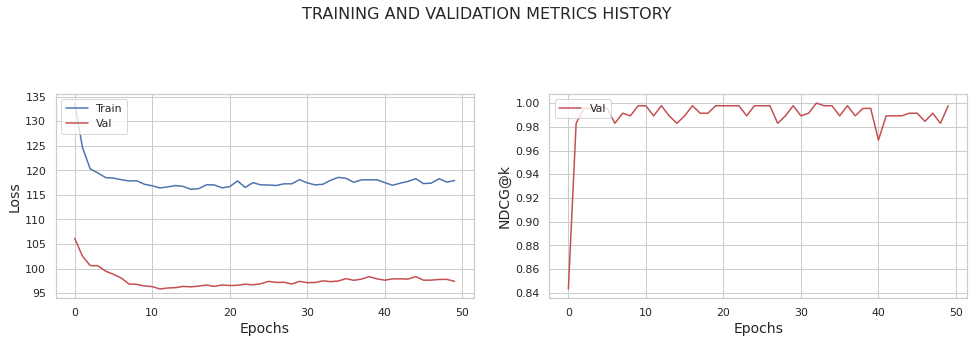

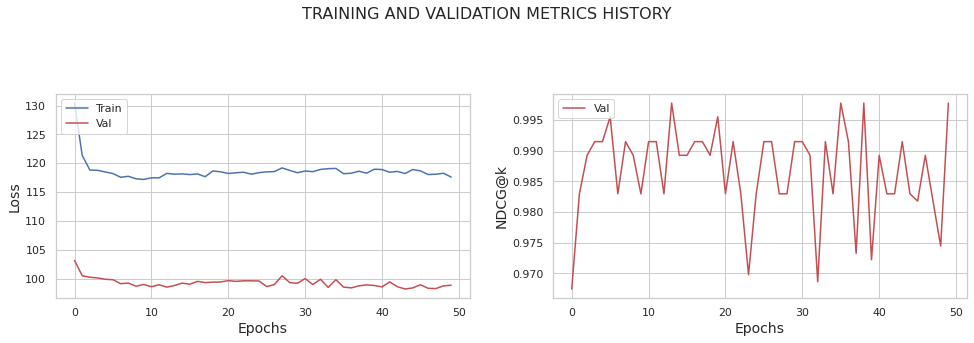

In [205]:
sparsity_percentage = 0.75
maps, ndcgs, precisions, recalls = train_tune_eval_pipeline(sparsity_percentage, run_n_times=20)

In [208]:
# maps, ndcgs, precisions, recalls = train_tune_eval_pipeline(sparsity_percentage, run_n_times=20)
metrics_at_sparsity_levels[str(sparsity_percentage)] = dict()
metrics_at_sparsity_levels[str(sparsity_percentage)]["map"] = maps.tolist()
metrics_at_sparsity_levels[str(sparsity_percentage)]["ndcgs"] = ndcgs.tolist()
metrics_at_sparsity_levels[str(sparsity_percentage)]["precisions"] = precisions.tolist()
metrics_at_sparsity_levels[str(sparsity_percentage)]["recalls"] = recalls.tolist()

import json

with open("../results/results_vae.json", "w") as fp:
    json.dump(metrics_at_sparsity_levels, fp)

### Training with 80% sparsity

In [209]:
sparsity_percentage = 0.80
with open("../results/results_vae.json", "r") as fp:
    metrics_at_sparsity_levels = json.load(fp)

Took 36.1335 seconds for training.
Took 36.9683 seconds for training.
Took 2.2641 seconds for prediction.
Took 37.5908 seconds for training.
Took 37.8537 seconds for training.
Took 2.2028 seconds for prediction.
Took 38.4927 seconds for training.
Took 38.7971 seconds for training.
Took 2.2765 seconds for prediction.
Took 39.1759 seconds for training.
Took 39.9866 seconds for training.
Took 2.3981 seconds for prediction.
Took 40.2951 seconds for training.
Took 41.0017 seconds for training.
Took 2.4403 seconds for prediction.
Took 41.4238 seconds for training.
Took 42.2645 seconds for training.
Took 2.5212 seconds for prediction.
Took 42.7557 seconds for training.
Took 43.0190 seconds for training.
Took 2.6252 seconds for prediction.
Took 43.4956 seconds for training.
Took 44.5343 seconds for training.
Took 2.6975 seconds for prediction.
Took 44.6583 seconds for training.
Took 45.2790 seconds for training.
Took 2.7405 seconds for prediction.
Took 45.9454 seconds for training.
Took 46.598

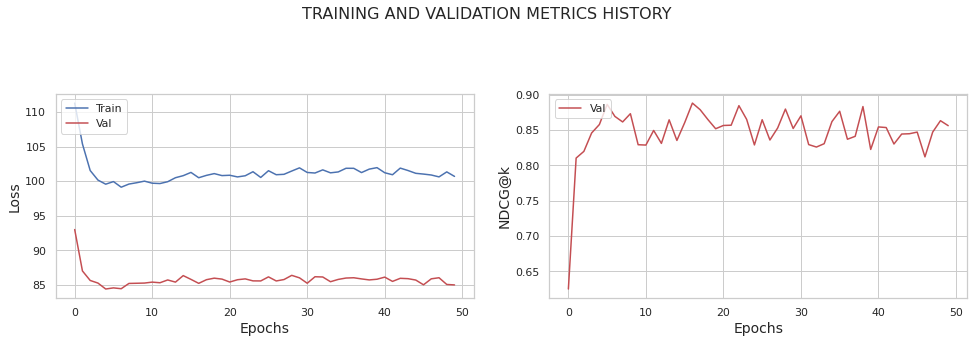

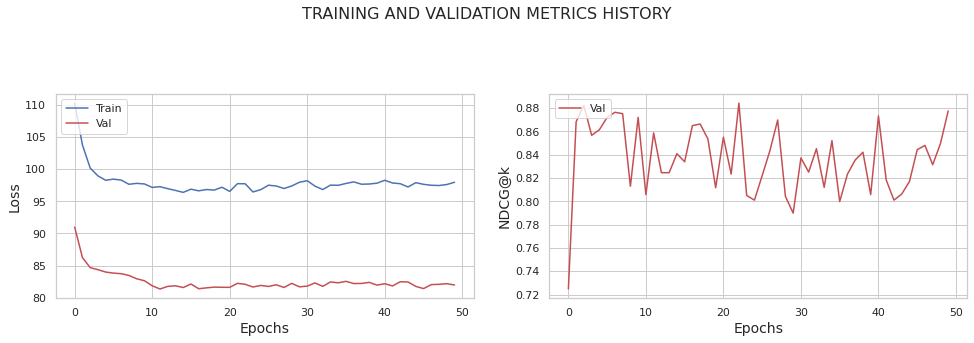

In [210]:
maps, ndcgs, precisions, recalls = train_tune_eval_pipeline(sparsity_percentage)
metrics_at_sparsity_levels[str(sparsity_percentage)] = dict()
metrics_at_sparsity_levels[str(sparsity_percentage)]["map"] = maps.tolist()
metrics_at_sparsity_levels[str(sparsity_percentage)]["ndcgs"] = ndcgs.tolist()
metrics_at_sparsity_levels[str(sparsity_percentage)]["precisions"] = precisions.tolist()
metrics_at_sparsity_levels[str(sparsity_percentage)]["recalls"] = recalls.tolist()


with open("../results/results_vae.json", "w") as fp:
    json.dump(metrics_at_sparsity_levels, fp)

### Training with 85% sparsity

In [211]:
sparsity_percentage = 0.85

with open("../results/results_vae.json", "r") as fp:
    metrics_at_sparsity_levels = json.load(fp)

Took 57.4366 seconds for training.
Took 57.4725 seconds for training.
Took 3.6656 seconds for prediction.
Took 57.8055 seconds for training.
Took 58.4546 seconds for training.
Took 3.7571 seconds for prediction.
Took 58.8729 seconds for training.
Took 59.3031 seconds for training.
Took 3.8585 seconds for prediction.
Took 59.8915 seconds for training.
Took 60.1463 seconds for training.
Took 3.8171 seconds for prediction.
Took 60.9869 seconds for training.
Took 61.5894 seconds for training.
Took 3.9625 seconds for prediction.
Took 61.7521 seconds for training.
Took 63.1930 seconds for training.
Took 4.0173 seconds for prediction.
Took 63.5251 seconds for training.
Took 63.4064 seconds for training.
Took 4.1614 seconds for prediction.
Took 64.8554 seconds for training.
Took 64.7740 seconds for training.
Took 4.2230 seconds for prediction.
Took 65.4935 seconds for training.
Took 66.1543 seconds for training.
Took 4.2958 seconds for prediction.
Took 66.2625 seconds for training.
Took 67.282

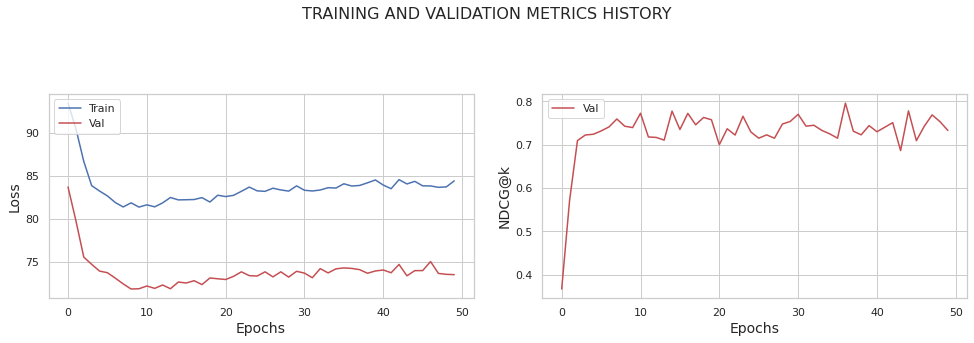

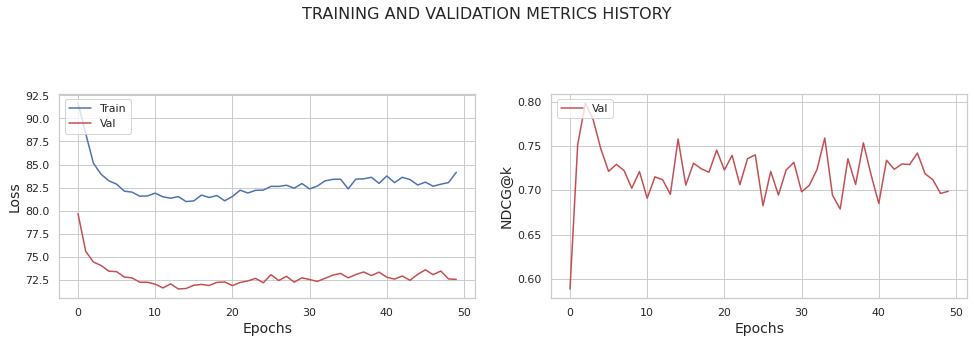

In [212]:
maps, ndcgs, precisions, recalls = train_tune_eval_pipeline(sparsity_percentage)
metrics_at_sparsity_levels[str(sparsity_percentage)] = dict()
metrics_at_sparsity_levels[str(sparsity_percentage)]["map"] = maps.tolist()
metrics_at_sparsity_levels[str(sparsity_percentage)]["ndcgs"] = ndcgs.tolist()
metrics_at_sparsity_levels[str(sparsity_percentage)]["precisions"] = precisions.tolist()
metrics_at_sparsity_levels[str(sparsity_percentage)]["recalls"] = recalls.tolist()


with open("../results/results_vae.json", "w") as fp:
    json.dump(metrics_at_sparsity_levels, fp)

### Training with 90% sparsity

In [213]:
sparsity_percentage = 0.90

with open("../results/results_vae.json", "r") as fp:
    metrics_at_sparsity_levels = json.load(fp)

Took 91.9296 seconds for training.
Took 79.0243 seconds for training.
Took 5.1894 seconds for prediction.
Took 81.0160 seconds for training.
Took 79.9914 seconds for training.
Took 5.4645 seconds for prediction.
Took 81.8290 seconds for training.
Took 83.6800 seconds for training.
Took 5.4001 seconds for prediction.
Took 84.2191 seconds for training.
Took 82.5962 seconds for training.
Took 5.4587 seconds for prediction.
Took 83.6000 seconds for training.
Took 88.0246 seconds for training.
Took 5.6438 seconds for prediction.
Took 85.0840 seconds for training.
Took 85.0799 seconds for training.
Took 5.6763 seconds for prediction.
Took 86.0658 seconds for training.
Took 100.3918 seconds for training.
Took 6.8486 seconds for prediction.
Took 90.2854 seconds for training.
Took 93.0818 seconds for training.
Took 6.1345 seconds for prediction.
Took 91.4786 seconds for training.
Took 90.0025 seconds for training.
Took 5.9736 seconds for prediction.
Took 90.0705 seconds for training.
Took 91.97

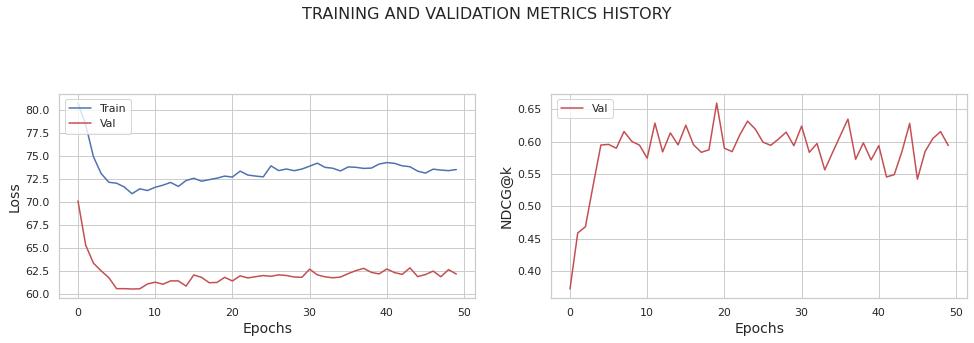

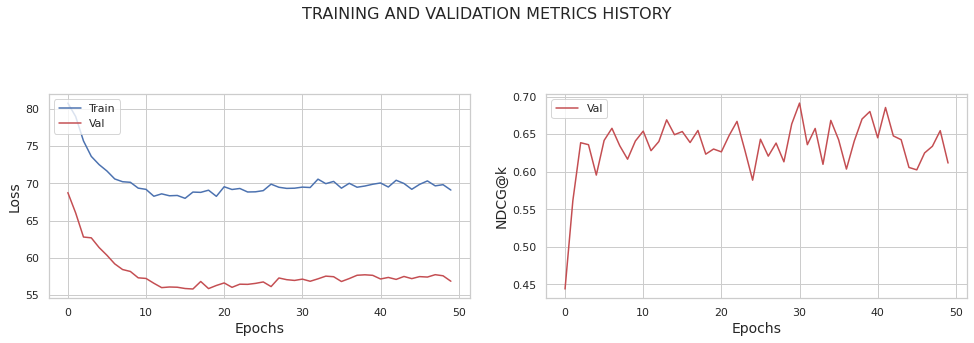

In [214]:
maps, ndcgs, precisions, recalls = train_tune_eval_pipeline(sparsity_percentage)
metrics_at_sparsity_levels[str(sparsity_percentage)] = dict()
metrics_at_sparsity_levels[str(sparsity_percentage)]["map"] = maps.tolist()
metrics_at_sparsity_levels[str(sparsity_percentage)]["ndcgs"] = ndcgs.tolist()
metrics_at_sparsity_levels[str(sparsity_percentage)]["precisions"] = precisions.tolist()
metrics_at_sparsity_levels[str(sparsity_percentage)]["recalls"] = recalls.tolist()

with open("../results/results_vae.json", "w") as fp:
    json.dump(metrics_at_sparsity_levels, fp)

### Training with 95% sparsity

In [6]:
sparsity_percentage = 0.95
with open("../results/results_vae.json", "r") as fp:
    metrics_at_sparsity_levels = json.load(fp)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use Model.fit, which supports generators.
Took 9.4165 seconds for training.
Took 9.0382 seconds for training.
Took 0.0921 seconds for prediction.
Took 10.2605 seconds for training.
Took 10.3954 seconds for training.
Took 0.1602 seconds for prediction.
Took 10.5172 seconds for training.
Took 10.6325 seconds for training.
Took 0.2142 seconds for prediction.
Took 11.1110 seconds for training.
Took 11.7217 seconds for training.
Took 0.2690 seconds for prediction.
Took 13.1671 seconds for training.
Took 12.3396 seconds for training.
Took 0.3305 seconds for prediction.
Took 13.0433 seconds for training.
Took 13.2504 seconds for training.
Took 0.3963 seconds for prediction.
Took 13.8071 seconds for training.
Took 14.1702 seconds for training.
Took 0.4768 seconds for prediction.
Took 15.0616 seconds for training.
Took 15.5059 seconds for training.
Took 0.5712 seconds for predictio

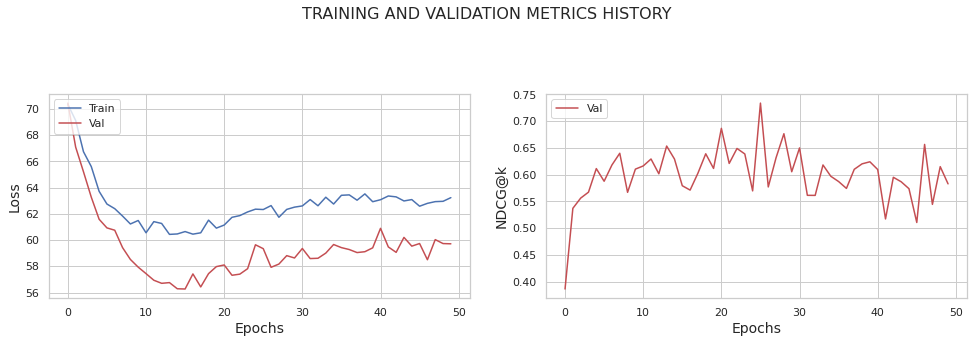

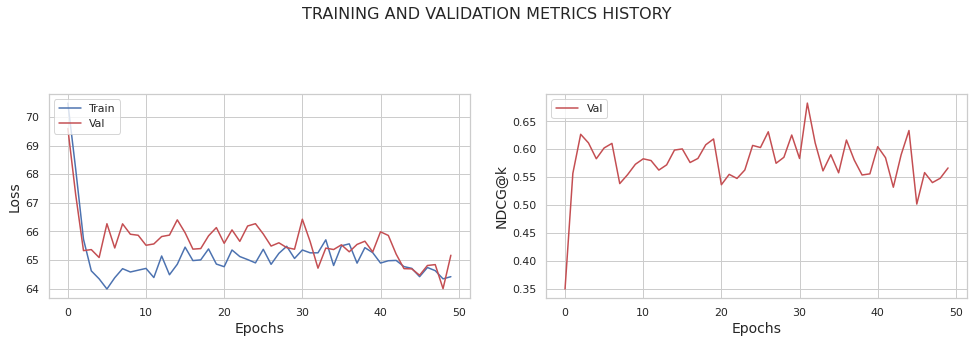

In [7]:
maps, ndcgs, precisions, recalls = train_tune_eval_pipeline(sparsity_percentage)
metrics_at_sparsity_levels[str(sparsity_percentage)] = dict()
metrics_at_sparsity_levels[str(sparsity_percentage)]["map"] = maps.tolist()
metrics_at_sparsity_levels[str(sparsity_percentage)]["ndcgs"] = ndcgs.tolist()
metrics_at_sparsity_levels[str(sparsity_percentage)]["precisions"] = precisions.tolist()
metrics_at_sparsity_levels[str(sparsity_percentage)]["recalls"] = recalls.tolist()

with open("../results/results_vae.json", "w") as fp:
    json.dump(metrics_at_sparsity_levels, fp)

In [ ]:
# sparsity_levels = list(map(lambda x: float(x), metrics_at_sparsity_levels))
# plt.plot(sparsity_levels, list(map(lambda x: x['ndcg'], metrics_at_sparsity_levels.values())), label="ndcg@10", marker = "o")
# plt.plot(sparsity_levels, list(map(lambda x: x['map'], metrics_at_sparsity_levels.values())), label="map@10", marker = "o")
# plt.plot(sparsity_levels, list(map(lambda x: x['recall'], metrics_at_sparsity_levels.values())), label="recall@10", marker = "o")
# plt.plot(sparsity_levels, list(map(lambda x: x['precision'], metrics_at_sparsity_levels.values())), label="precision@10", marker = "o")
# plt.title("Metrics as function of Sparsity")
# plt.xlabel("Sparsity %")
# plt.legend()
# plt.savefig("../results/metrics_over_sparsity.png")
# plt.show()

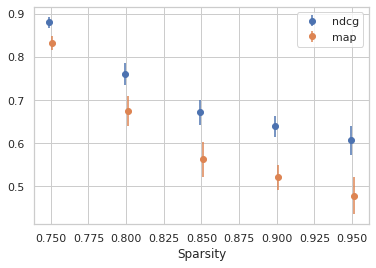

In [13]:
from matplotlib.transforms import Affine2D

sparsity_levels = list(map(lambda x: float(x), metrics_at_sparsity_levels))
ndcg_mean = np.array(list(map(lambda x: x['ndcgs'], metrics_at_sparsity_levels.values()))).mean(axis=1)
ndcg_std = np.array(list(map(lambda x: x['ndcgs'], metrics_at_sparsity_levels.values()))).std(axis=1)
map_mean = np.array(list(map(lambda x: x['map'], metrics_at_sparsity_levels.values()))).mean(axis=1)
map_std = np.array(list(map(lambda x: x['map'], metrics_at_sparsity_levels.values()))).std(axis=1)


fig, ax = plt.subplots()

trans1 = Affine2D().translate(-0.001, 0.0) + ax.transData
trans2 = Affine2D().translate(0.001, 0.0) + ax.transData
er1 = ax.errorbar(sparsity_levels, ndcg_mean, ndcg_std, linestyle='None', marker='o', label = "ndcg", transform=trans1)
er2 = ax.errorbar(sparsity_levels, map_mean, map_std, linestyle='None', marker='o', label = "map", transform=trans2)
plt.legend()
plt.xlabel("Sparsity")

plt.show()

In [ ]:
import json

with open("../results/results_vae.json", "w") as fp:
    json.dump(metrics_at_sparsity_levels, fp)

# 6 References

[Liang, Dawen, et al, 2018] [Liang, Dawen, et al. "Variational autoencoders for collaborative filtering." Proceedings of the 2018 World Wide Web Conference. 2018.](https://dl.acm.org/doi/pdf/10.1145/3178876.3186150?casa_token=zul5haircsAAAAAA:iIKn7y-xWwSeqaP-MmmyUaJoJuNZX9Fx1aXeFJwkwtMpVDCrPMW3kZjuYo1LKhSuMeUMNf1mbP2o) 

[Kingma et al, 2013] [Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes."  (2013).](https://arxiv.org/pdf/1312.6114.pdf)

[Burgess et al, 2018] [Burgess, Christopher P., et al. "Understanding disentangling in $\beta $-VAE." (2018)](https://arxiv.org/pdf/1804.03599.pdf)

[Higgins et al, 2016] [Higgins, Irina, et al. "beta-vae: Learning basic visual concepts with a constrained variational framework." (2016).](https://openreview.net/pdf?id=Sy2fzU9gl)


[Bowman et al, 2015] [Samuel R. Bowman, Luke Vilnis, Oriol Vinyals, Andrew M. Dai, Rafal Jozefowicz,
and Samy Bengio. 2015. Generating sentences from a continuous space. (2015).](https://arxiv.org/pdf/1511.06349.pdf)
